In [27]:
#Data Processing
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

#Deep Learning 
import torch
import torch.nn as nn 
from torchvision import models, transforms
from PIL import Image

#Image Processing
import os
from pathlib import Path 
import joblib
import time

#Machine Learning
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

#Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

#Set Random seeds
np.random.seed(42)
torch.manual_seed(42)

In [28]:
#Configuration

USE_SUBSET = True
SUBSET_SIZE = 2000
BATCH_SIZE = 32

In [29]:
image_dir = Path('myntraDataSet/images')

image_paths = list(image_dir.glob('*.jpg'))

fashion_data = []

for img_path in image_paths:
    fashion_data.append({
        'image_id' : img_path.stem,
        'image_path' : str(img_path),
        'filename' : img_path.name
    })

fashion_df = pd.DataFrame(fashion_data)

fashion_df = fashion_df.sample(SUBSET_SIZE, random_state=42).reset_index(drop=True)

fashion_df.head()

,image_id,image_path,filename
0,34522,myntraDataSet\images\34522.jpg,34522.jpg
1,6807,myntraDataSet\images\6807.jpg,6807.jpg
2,20194,myntraDataSet\images\20194.jpg,20194.jpg
3,27865,myntraDataSet\images\27865.jpg,27865.jpg
4,45293,myntraDataSet\images\45293.jpg,45293.jpg


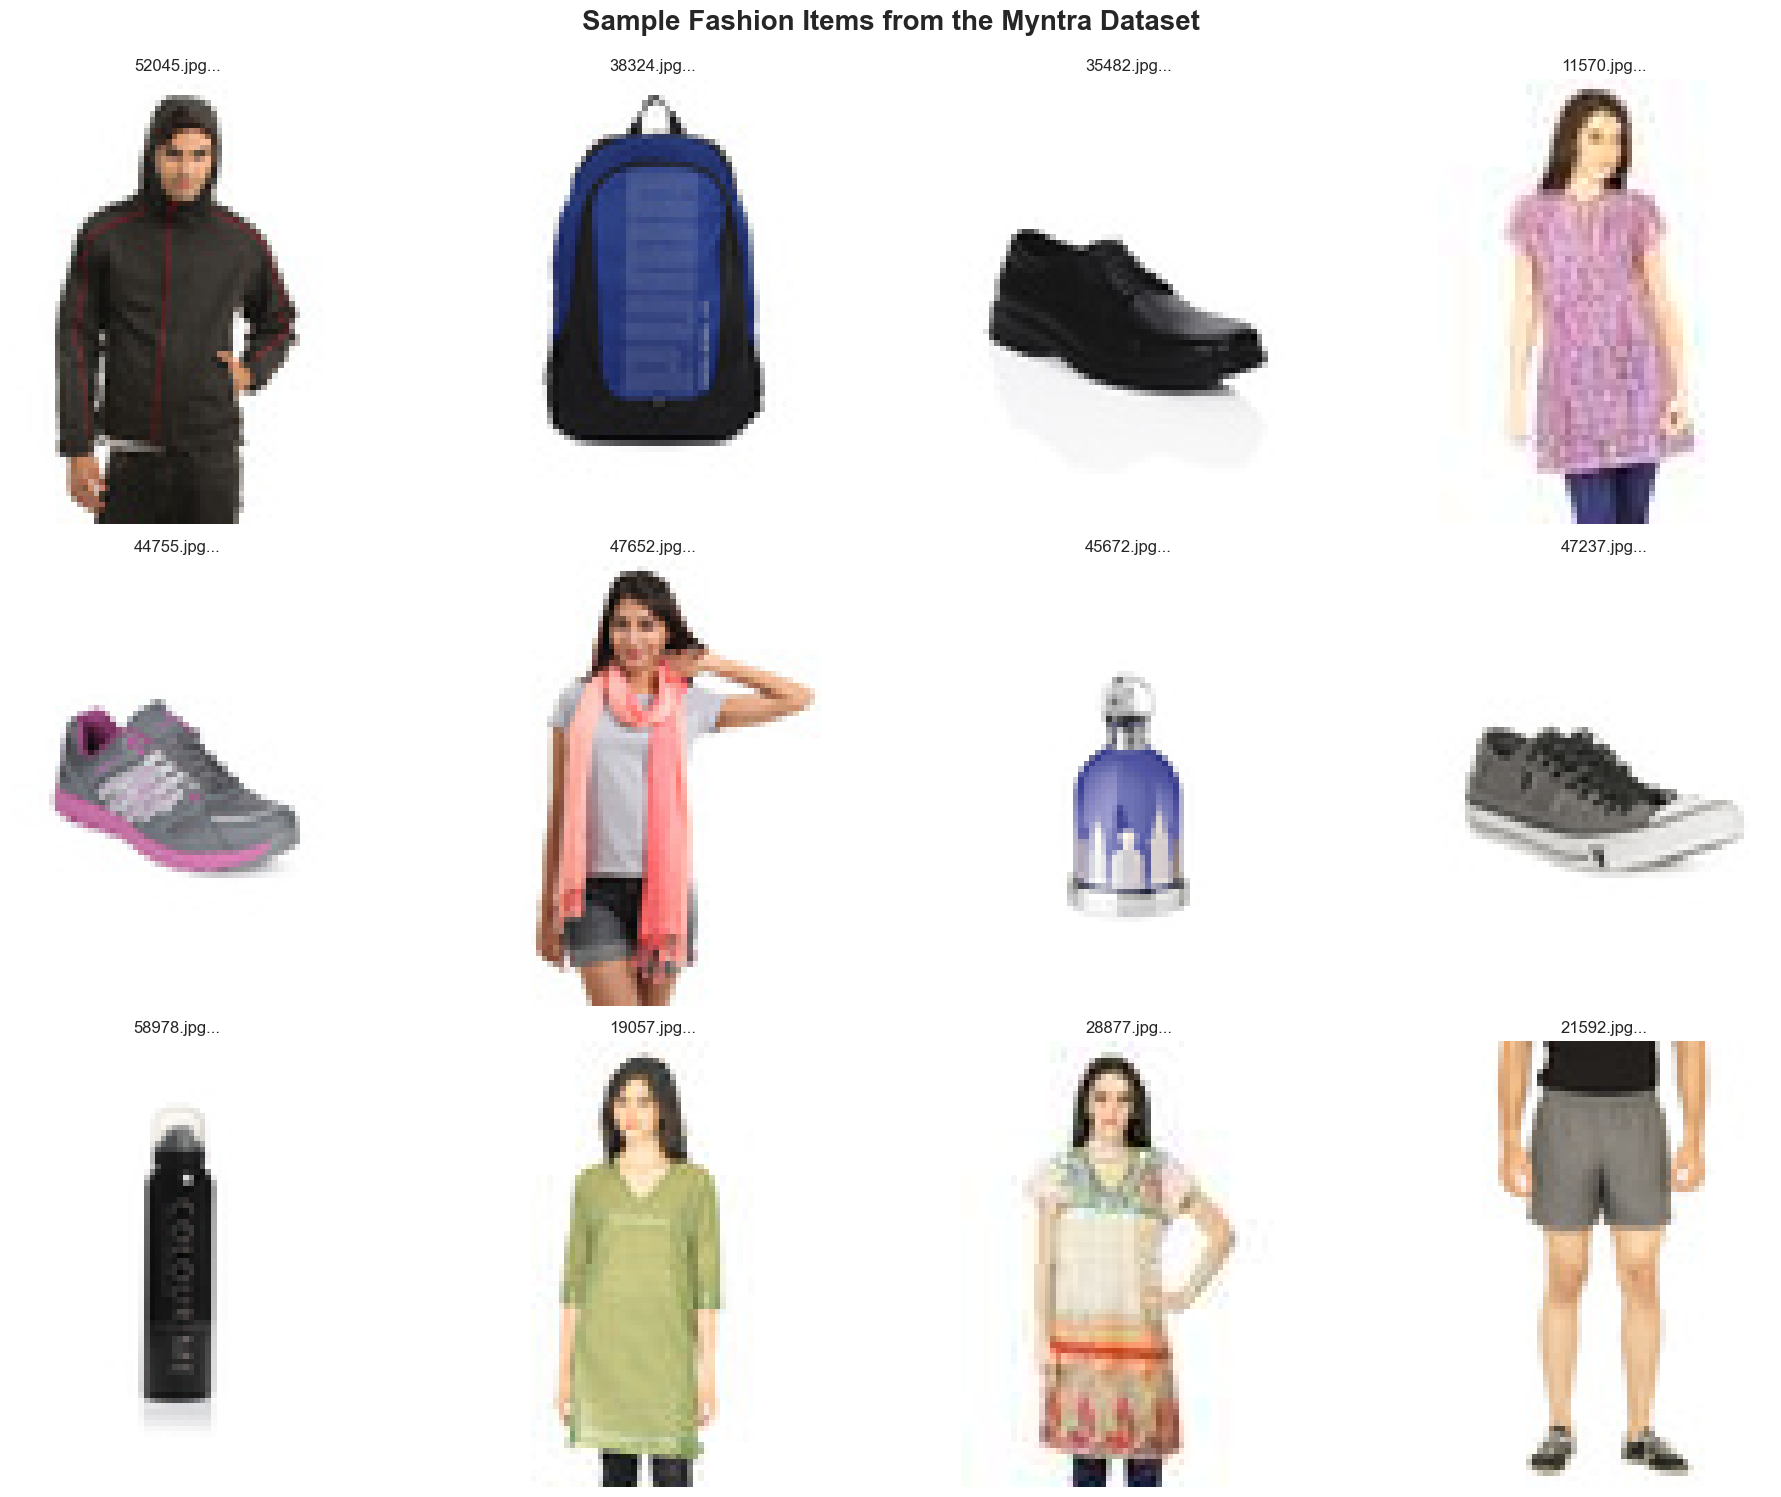

In [30]:
#Display Sample Images

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Sample Fashion Items from the Myntra Dataset', fontsize=20, fontweight='bold', y=0.995)

sample_items = fashion_df.sample(min(12, len(fashion_df)))

for idx, (ax, (_, item)) in enumerate(zip(axes.flat, sample_items.iterrows())):
    try:
        img = Image.open(item['image_path'])
        ax.imshow(img)
        ax.set_title(f"{item['filename'][:25]}...", fontsize=12)
        ax.axis('off')
    except Exception as e:
        ax.text(0.5, 0.5, f'Error loading {item["filename"][:25]}', ha='center', va='center', fontsize=9)
        ax.axis('off')
plt.tight_layout()
plt.show()

In [31]:
model = models.resnet18(pretrained=True)

model = nn.Sequential(*list(model.children())[:-1])
model = model.to('cpu')
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]

    )
])

In [32]:
all_features = []
failed_images = []
start_time = time.time()

for i in range(0, len(fashion_df), BATCH_SIZE):
    batch_df = fashion_df.iloc[i:i+BATCH_SIZE]
    batch_images = []
    batch_indices = []

    for idx, row in batch_df.iterrows():
        try:
            img = Image.open(row['image_path']).convert('RGB')
            img_tensor = transform(img)
            batch_images.append(img_tensor)
            batch_indices.append(idx)
        except Exception as e:
            failed_images.append(row['filename'])
            continue
    if batch_images:
        batch_tensor = torch.stack(batch_images).to('cpu')

        with torch.no_grad():
            features = model(batch_tensor)
            features = features.squeeze().cpu().numpy()

            if len(features.shape) == 1:
                features = features.reshape(1, -1)
            all_features.extend(features)

    if (i + BATCH_SIZE) % 200 == 0 or (i + BATCH_SIZE) >= len(fashion_df):
        elapsed = time.time() - start_time
        progress = min((i + BATCH_SIZE) / len(fashion_df) * 100, 100)
        print(f"Progress: {progress:.1f}% | Processed:{len(all_features):,}/{len(fashion_df):,} | Time : {elapsed:.1f}s")

features_array = np.array(all_features)

if failed_images:
    fashion_df = fashion_df[~fashion_df['filename'].isin(failed_images)].reset_index(drop=True)

elapsed_time = time.time() - start_time


Progress: 40.0% | Processed:800/2,000 | Time : 14.1s
Progress: 80.0% | Processed:1,600/2,000 | Time : 30.2s
Progress: 100.0% | Processed:2,000/2,000 | Time : 38.3s


In [33]:
#Build K-Nearest Neighbors model

knn_model = NearestNeighbors(
    n_neighbors=min(20, len(features_array)),
    metric='cosine',
    algorithm='brute'
)

knn_model.fit(features_array)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",20
,"radius radius: float, default=1.0Range of parameter space to use by default for :meth:`radius_neighbors`queries.",1.0
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'brute'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'cosine'
,"p p: float (positive), default=2Parameter for the Minkowski metric fromsklearn.metrics.pairwise.pairwise_distances. When p = 1, this isequivalent to using manhattan_distance (l1), and euclidean_distance(l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.",2
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [34]:
n_test = min(3, len(fashion_df))

for test_num in range(n_test):
    test_idx = np.random.randint(0, len(fashion_df))
    query_item = fashion_df.iloc[test_idx]

    query_features = features_array[test_idx].reshape(1,-1)
    distances, indices = knn_model.kneighbors(query_features, n_neighbors=7)

    indices = indices[0][1:]
    distances = distances[0][1:]

    recommendations = fashion_df.iloc[indices].copy()
    recommendations['similarity'] = 1 - distances

    print("Top Recommendations")
    for i, (_, rec) in enumerate(recommendations.iterrows(),1):
        print(f" {i}. {rec['filename'][:35]:35} |Similarity: {rec['similarity']:2%}")
    print()

Top Recommendations
 1. 2194.jpg                            |Similarity: 95.790422%
 2. 2032.jpg                            |Similarity: 95.646381%
 3. 2239.jpg                            |Similarity: 95.281988%
 4. 2201.jpg                            |Similarity: 95.023298%
 5. 2588.jpg                            |Similarity: 94.291079%
 6. 29051.jpg                           |Similarity: 94.262040%

Top Recommendations
 1. 26068.jpg                           |Similarity: 96.246749%
 2. 22374.jpg                           |Similarity: 95.321053%
 3. 12005.jpg                           |Similarity: 95.308805%
 4. 26066.jpg                           |Similarity: 95.280570%
 5. 26041.jpg                           |Similarity: 94.784033%
 6. 11108.jpg                           |Similarity: 94.476032%

Top Recommendations
 1. 10877.jpg                           |Similarity: 92.607218%
 2. 4750.jpg                            |Similarity: 92.461932%
 3. 8553.jpg                            |S

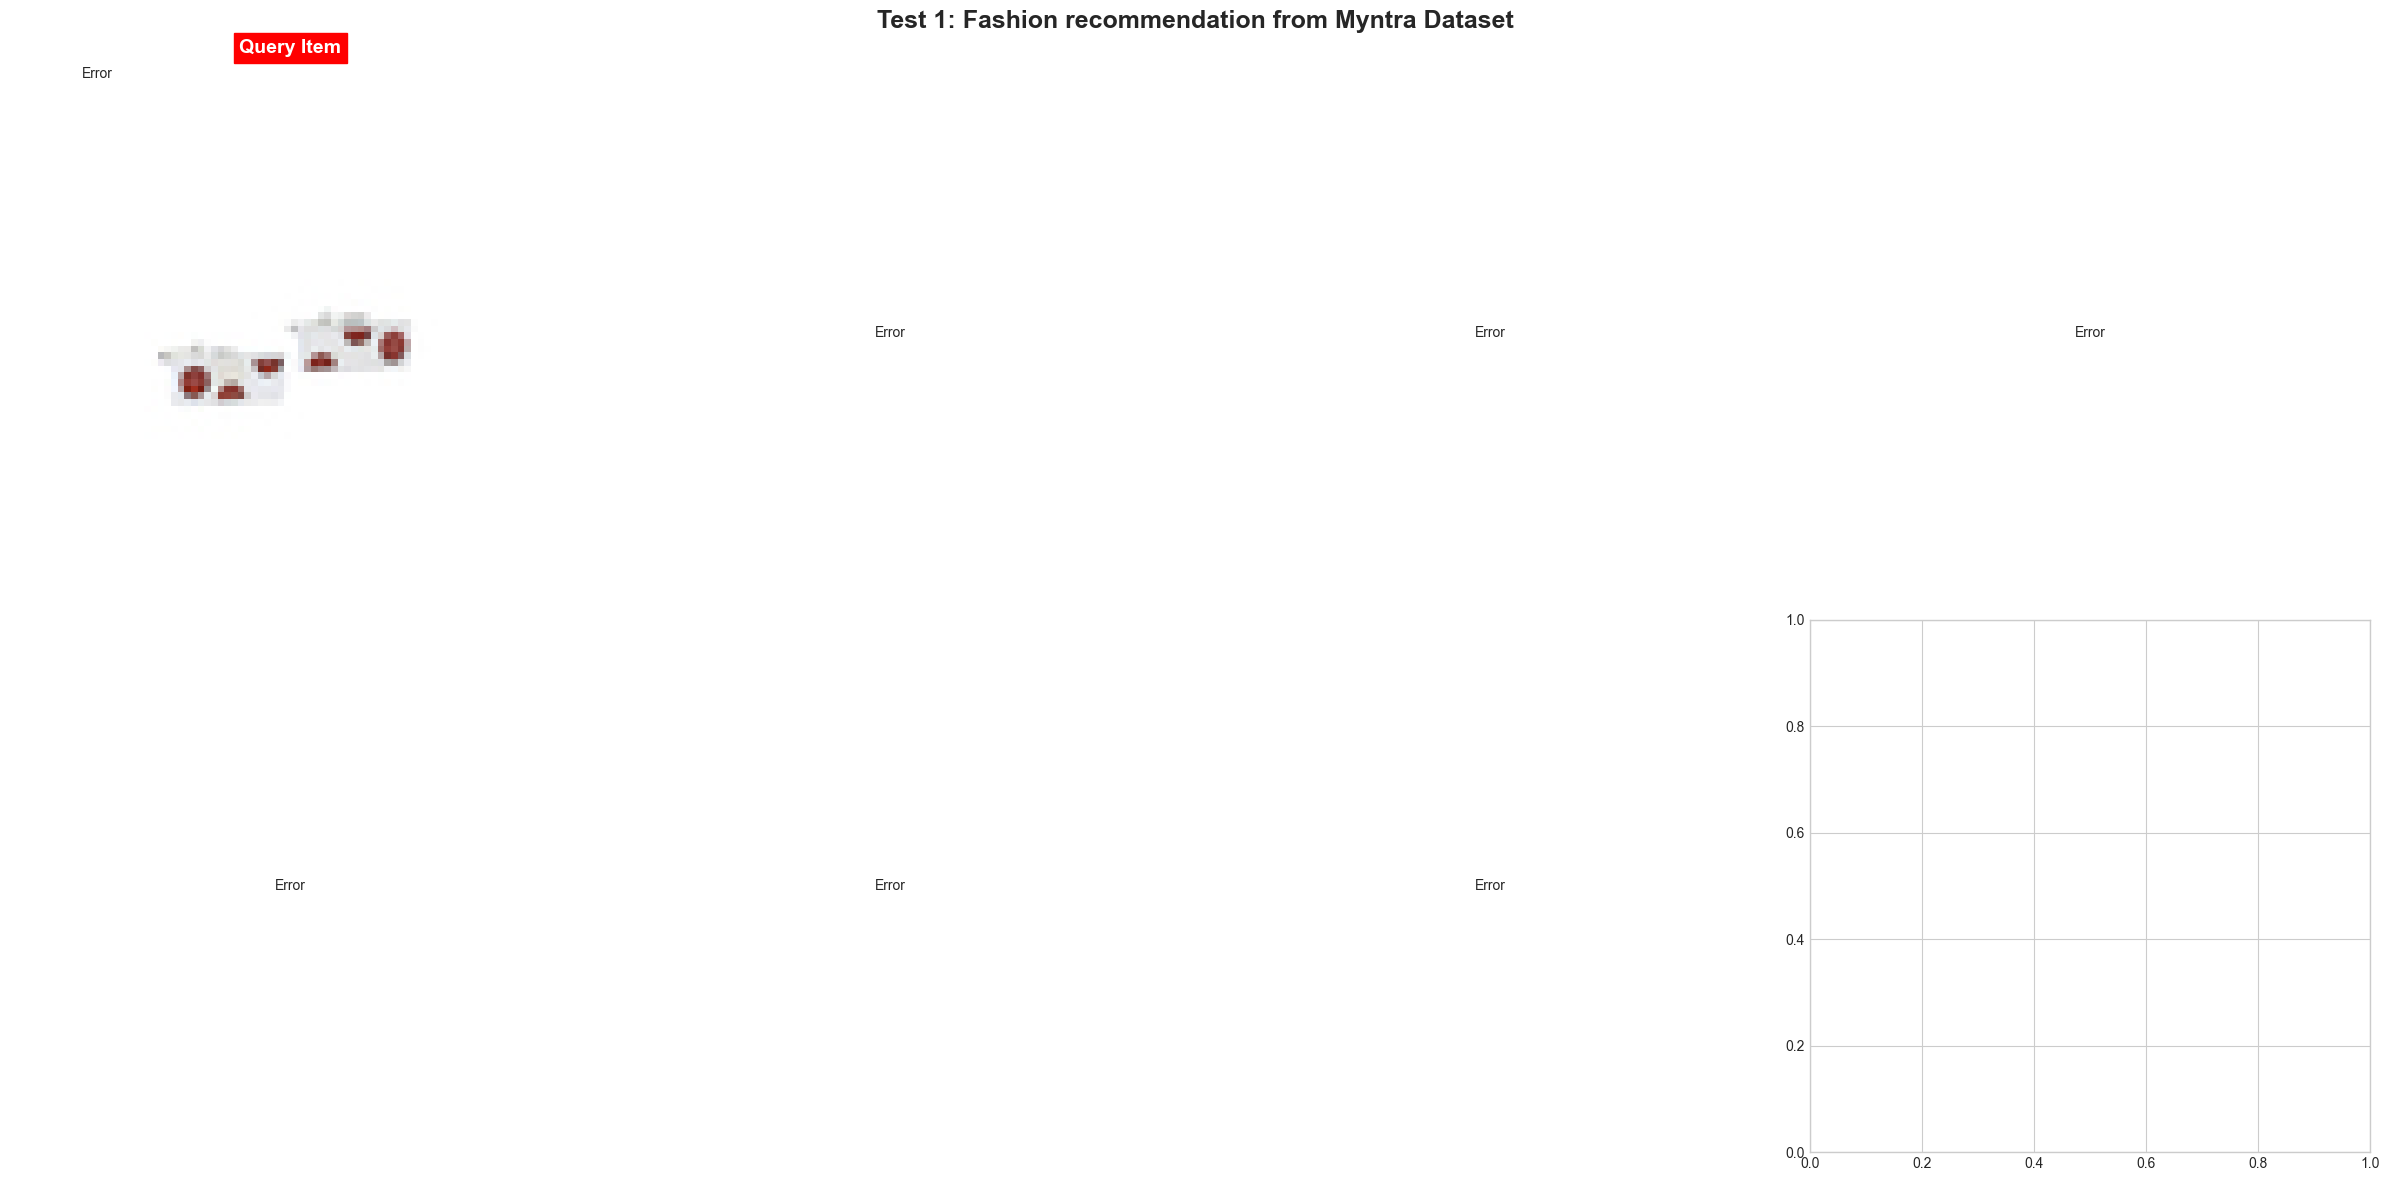

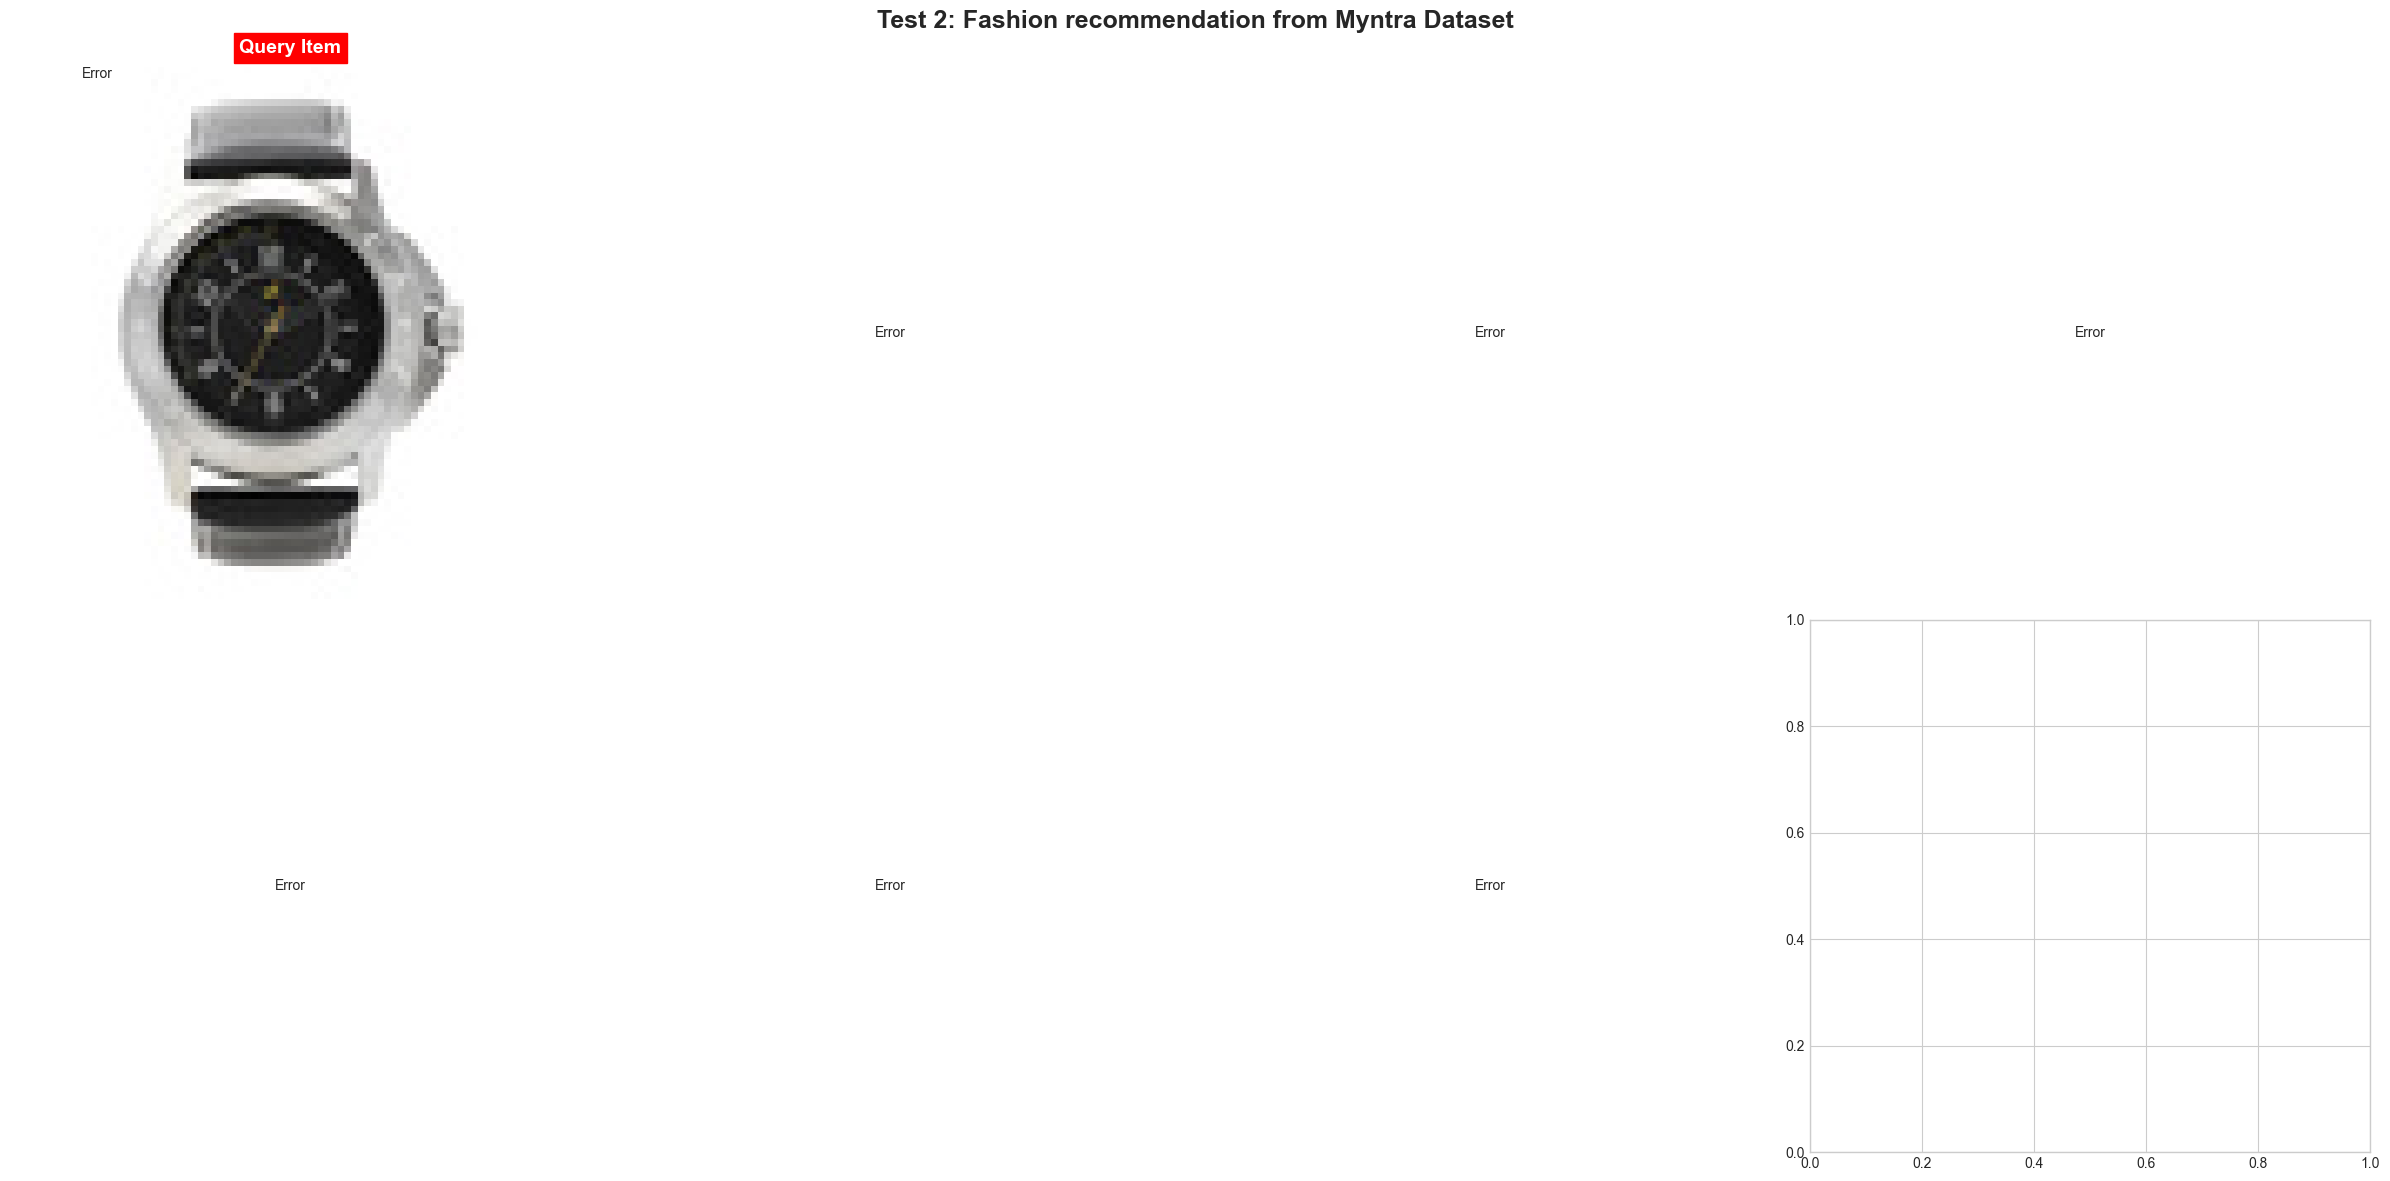

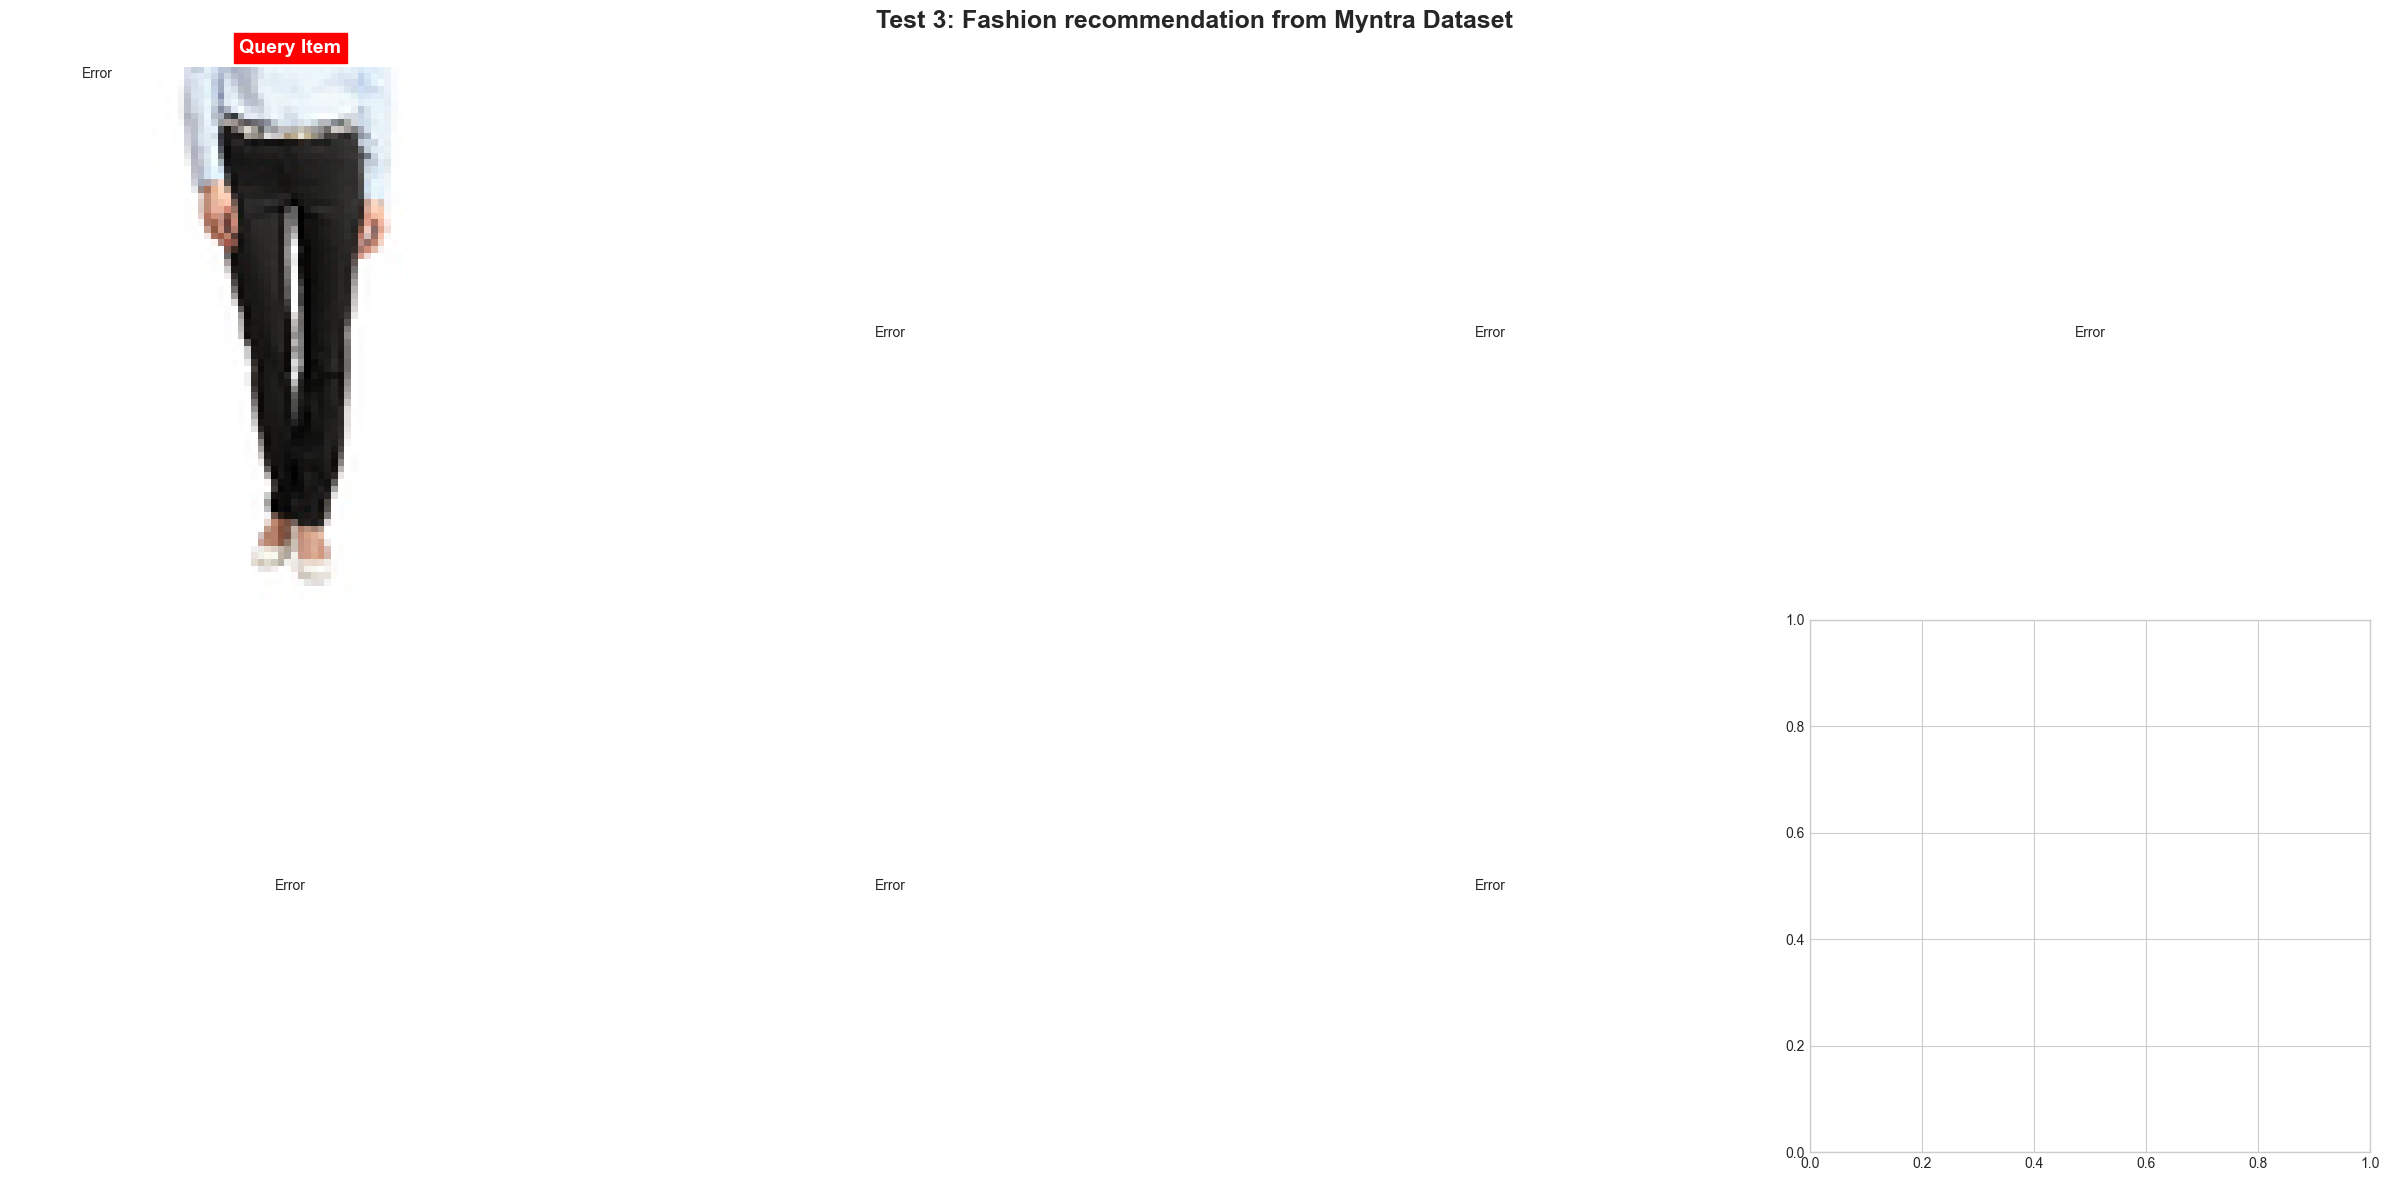

In [35]:
n_test = min(3, len(fashion_df))

for test_num in range(n_test):
    test_idx = np.random.randint(0, len(fashion_df))
    query_item = fashion_df.iloc[test_idx]

    query_features = features_array[test_idx].reshape(1,-1)
    distances, indices = knn_model.kneighbors(query_features, n_neighbors=7)

    indices = indices[0][1:]
    distances = distances[0][1:]

    recommendations = fashion_df.iloc[indices].copy()
    recommendations['similarity'] = 1 - distances

    fig, axes = plt.subplots(2,4, figsize=(24,12))
    fig.suptitle(f"Test {test_num + 1}: Fashion recommendation from Myntra Dataset", fontsize=18, fontweight='bold')

    try:
        query_img = Image.open(query_item['image_path'])
        axes[0,0].imshow(query_img)
        axes[0,0].set_title('Query Item', fontweight='bold',fontsize=14,
                            color='white', backgroundcolor='red', pad=10)
        axes=[0,0].axis('off')
    except:
        axes[0,0].text(0.5,0.5, "Error", ha='center', va='center')
        axes[0,0].axis('off')
    
    for idx, (ax, (_, rec)) in enumerate(zip(axes.flat[1:], recommendations.iterrows())):
        if idx < 7:
            try:
                rec_img = Image.open(rec['image_path'])
                axes.imshow(rec_img)
                ax.set_title(f"Match: {rec['similarity']:.1%}",
                            fontsize=12, fontweight='bold', color='green')
                ax.axis('off')
            except:
                ax.text(0.5, 0.5, "Error", ha='center', va='center')
                ax.axis('off')
    plt.tight_layout()
    plt.show()

In [36]:
os.makedirs('models', exist_ok=True)

np.save('models/fashion_features.npy', features_array)

fashion_df.to_csv('models/fashion_metadata.csv', index=False)

model_data = {
    'features' : features_array,
    'metadata' : fashion_df,
    'feature_extractor_type' : 'resnet18',
    'dataset' : 'myntra',
    'num_items' : len(fashion_df),
    'feature_dim' : features_array.shape[1]
}

joblib.dump(model_data, 'models/fashion_model.pkl')

file_size = os.path.getsize('models/fashion_model.pkl')/(1024**2)
file_size

4.007585525512695